In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pathlib
import random
import os

import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from keras.applications import mobilenet
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import datasets, layers, models


#Suppressing Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
tf.keras.backend.clear_session()

# Preprocessing

In [ ]:
train_path = './Covid19-dataset/train'
test_path = './Covid19-dataset/test'

In [ ]:
img_size = 224
batch = 16

# Image Loader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def generate_data(DIR):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch,
        shuffle=True,
        seed=42,
        class_mode='categorical',
        target_size=(img_size, img_size),
        classes={'Normal': 0, 'Viral Pneumonia': 1,'Covid': 2}
    )
    return generator

In [ ]:
train_generator = generate_data(train_path)

test_generator = generate_data(test_path)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


# Modelling

In [ ]:
base_model = EfficientNetB7(weights='imagenet', include_top=False,
                            input_shape=(img_size, img_size,3))

# freeze extraction layers
base_model.trainable = False

# add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512 , activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

258076736/258076736 [==============================] - 12s 0us/step


## Save our best model during training

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint('model.hdf5',
                                 save_best_only=True)]

In [ ]:
opt = Adam(learning_rate=0.001)
model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# Training the Model

In [ ]:
history = model.fit(train_generator,
                    epochs = 100,
                    validation_data = test_generator,
                    verbose = True,
                   callbacks=callbacks)

Epoch 1/100
16/16 [==============================] - 48s 2s/step - loss: 1.3164 - accuracy: 0.3546 - val_loss: 1.1608 - val_accuracy: 0.3939
Epoch 2/100
16/16 [==============================] - 26s 2s/step - loss: 1.1148 - accuracy: 0.3825 - val_loss: 1.0911 - val_accuracy: 0.4242
Epoch 3/100
16/16 [==============================] - 25s 2s/step - loss: 1.1121 - accuracy: 0.4263 - val_loss: 1.1195 - val_accuracy: 0.3030
Epoch 4/100
16/16 [==============================] - 25s 2s/step - loss: 1.1026 - accuracy: 0.4064 - val_loss: 1.1648 - val_accuracy: 0.3939
Epoch 5/100
16/16 [==============================] - 25s 2s/step - loss: 1.1156 - accuracy: 0.4223 - val_loss: 1.1755 - val_accuracy: 0.3939
Epoch 6/100
16/16 [==============================] - 26s 2s/step - loss: 1.1185 - accuracy: 0.4183 - val_loss: 1.0769 - val_accuracy: 0.3939
Epoch 7/100
16/16 [==============================] - 25s 2s/step - loss: 1.1024 - accuracy: 0.3984 - val_loss: 1.1083 - val_accuracy: 0.6818
Epoch 8/100
1

# Evaluation

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

### Loading best model

In [ ]:
model = load_model('./model.hdf5')

In [ ]:
def learning_curve(model_fit, key='accuracy', ylim=(0, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'val'], loc='best')
    plt.show()

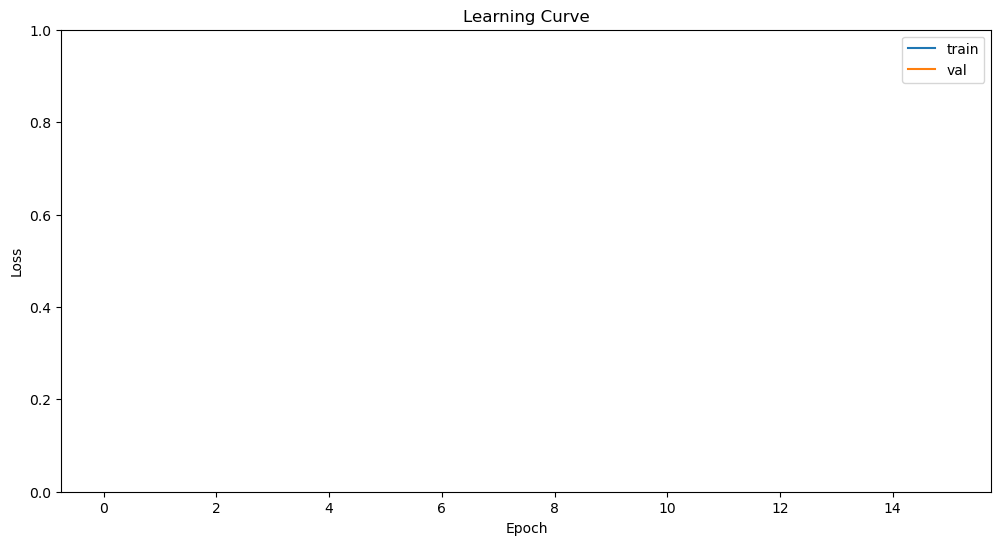

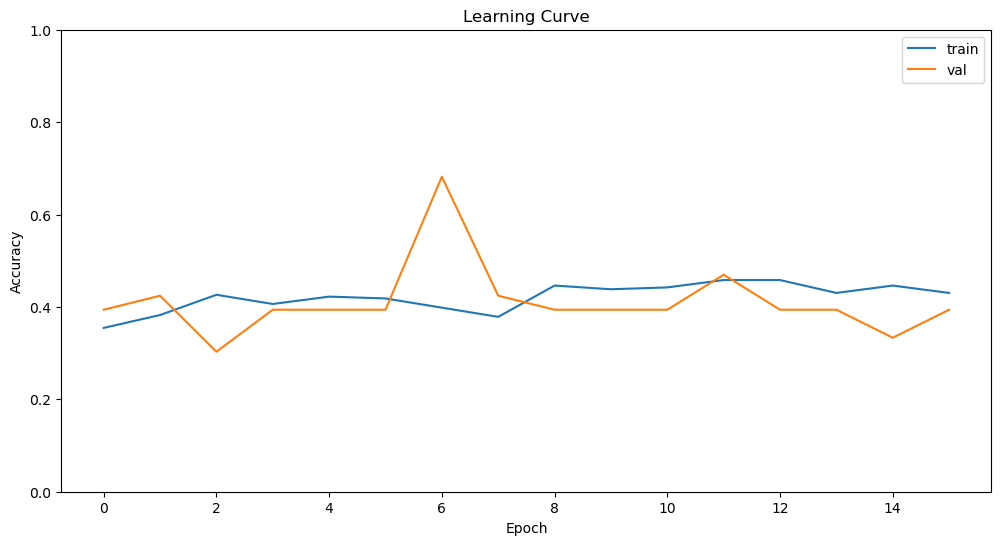

In [ ]:
learning_curve(history,'loss', ylim=(0,1))
learning_curve(history, 'accuracy', ylim=(0,1))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0)) 

5/5 [==============================] - 9s 873ms/step - loss: 1.0688 - accuracy: 0.3939
Loss: 106.876
Accuracy: 39.394
